# Housing Prices: Advanced Regression Techniques

**Result:** 0.12240 Top 18%


# Overview of Steps

1. Exploratory Data Analysis
2. Replace Missing Values
3. Establish Baseline RMSLE Score
4. Feature Engineering
5. Modeling
6. Make and Submit Prediction

In [303]:
import pandas as pd
import numpy as np
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['Train'] = 1
test['Train'] = 0
test['SalePrice'] = np.NaN

# 1. Exploratory Data Analysis

**First apply Log Tranformation to target variable (SalePrice)**

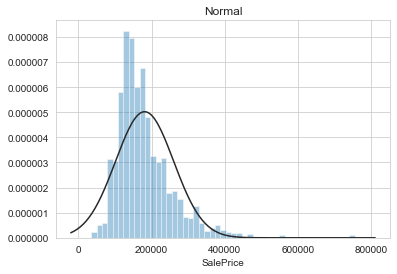

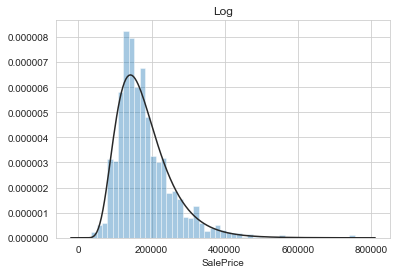

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

y = train['SalePrice']
plt.figure(1); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(2); plt.title('Log')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [304]:
train["SalePrice_Log"] = np.log1p(train["SalePrice"])
combined = pd.concat([train,test])

**Split columns into Numeric and Categorical lists**

In [305]:
numeric_columns_list = []
categorical_columns_list = []

for col in combined.columns:
    column_var = combined[col].dtype
    column_var = str(column_var)
    if column_var == 'object':
        categorical_columns_list.append(col)
    else:
        numeric_columns_list.append(col)

print('Numeric Columns:', len(numeric_columns_list))
print('Non-Numeric Columns:',len(categorical_columns_list))

numeric_columns_list.remove('Id')
numeric_columns_list.remove('SalePrice')
numeric_columns_list.remove('SalePrice_Log')

Numeric Columns: 40
Non-Numeric Columns: 43


**Numeric Columns Histograms**

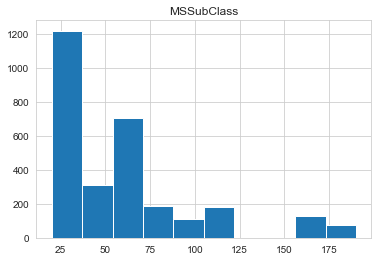

/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


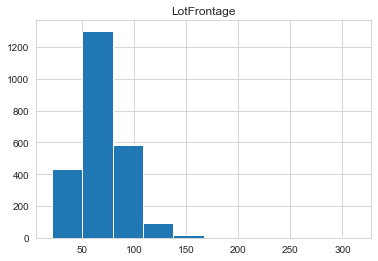

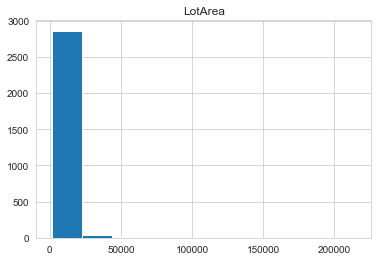

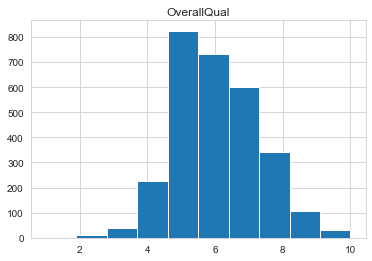

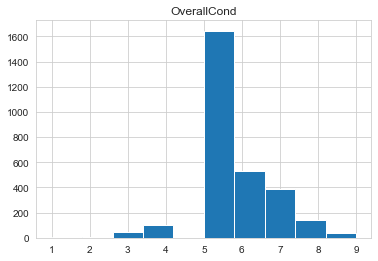

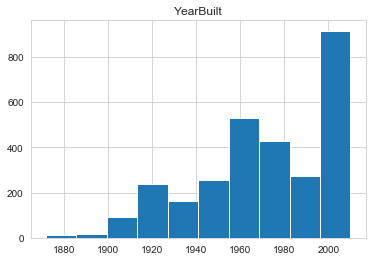

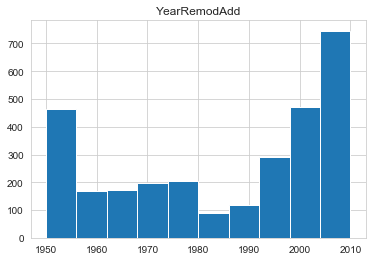

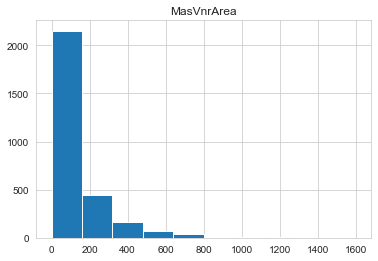

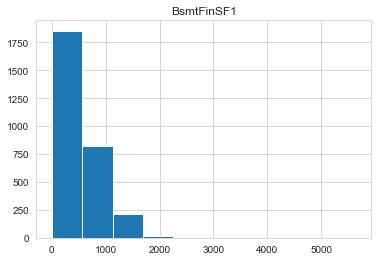

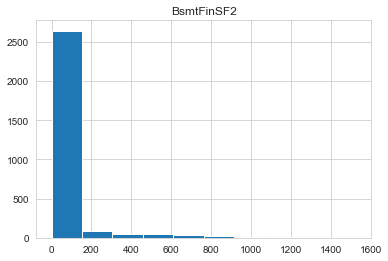

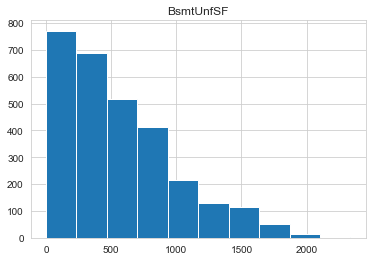

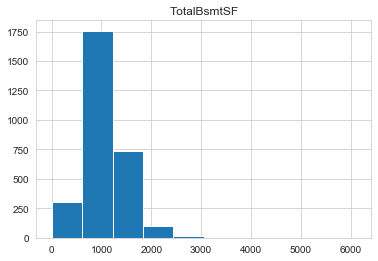

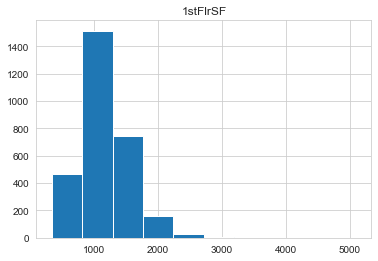

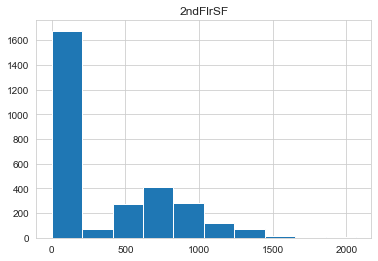

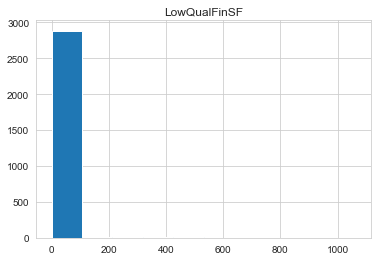

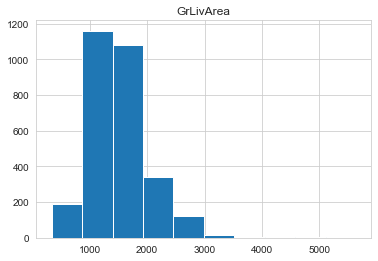

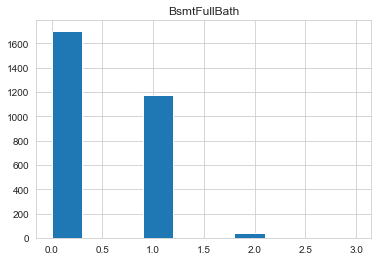

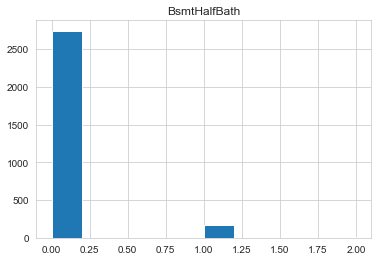

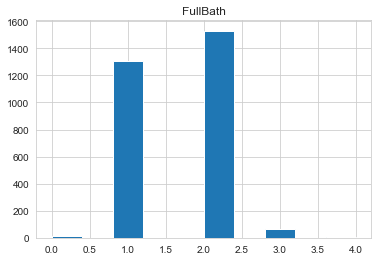

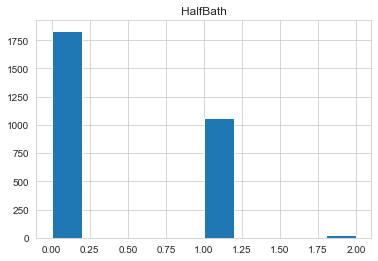

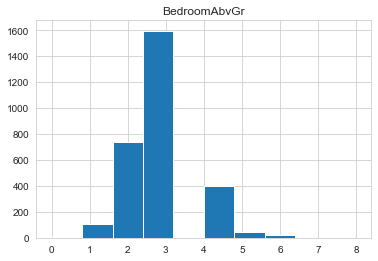

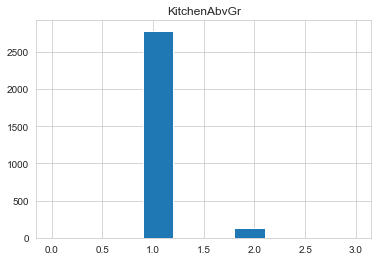

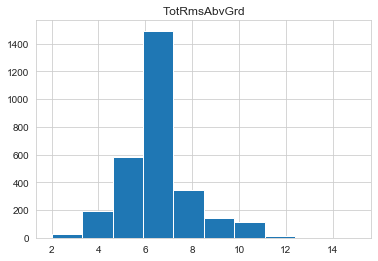

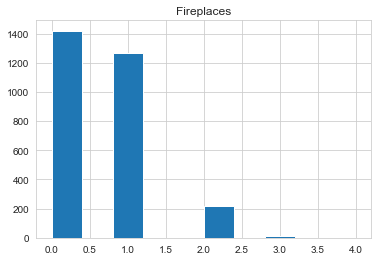

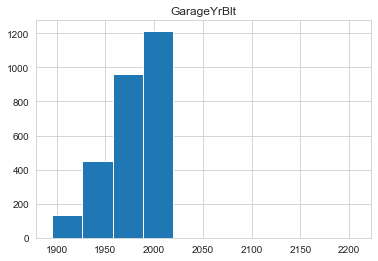

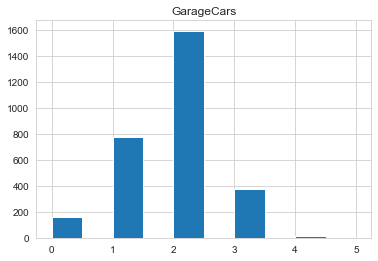

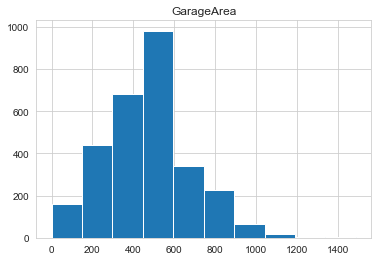

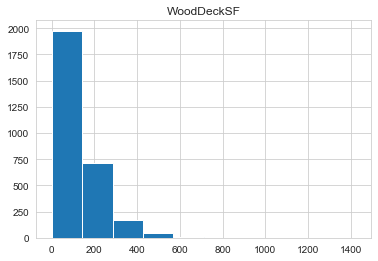

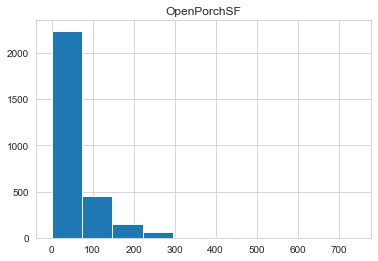

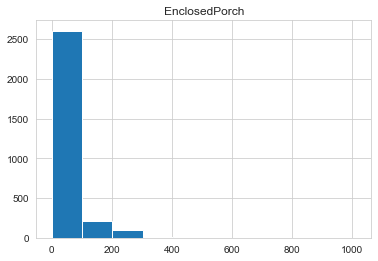

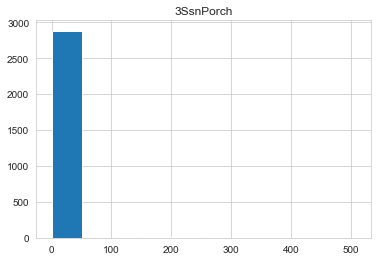

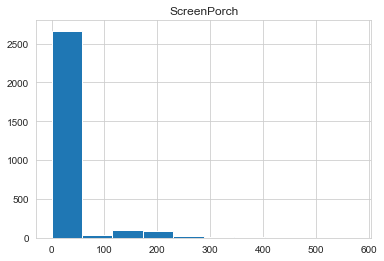

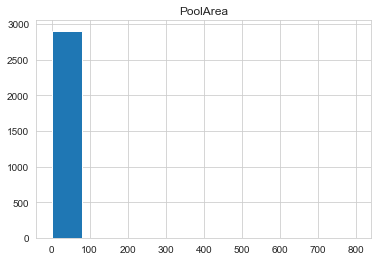

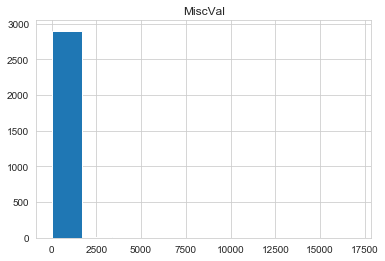

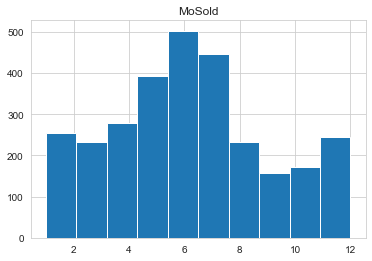

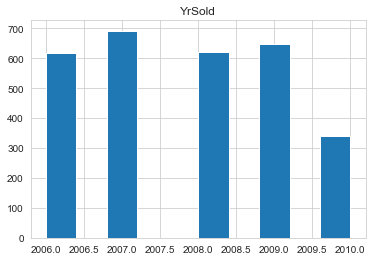

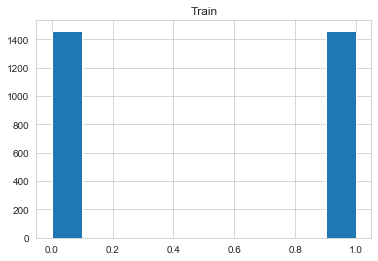

In [230]:
for feature in combined[numeric_columns_list].columns:
    plt.hist(combined[feature])
    plt.title(feature)
    plt.show()

**Categorical Columns Violinplots**

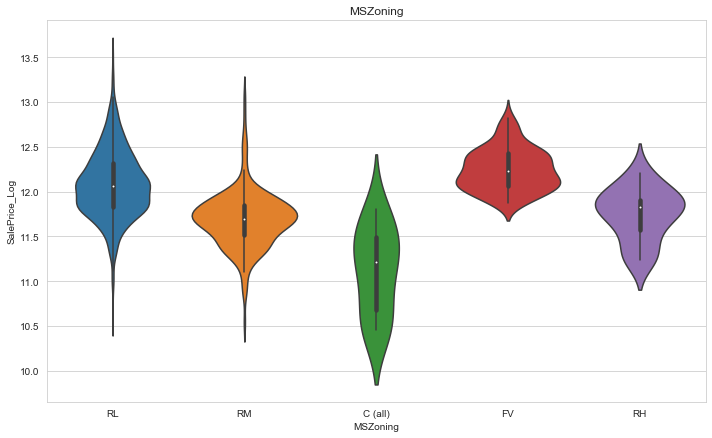

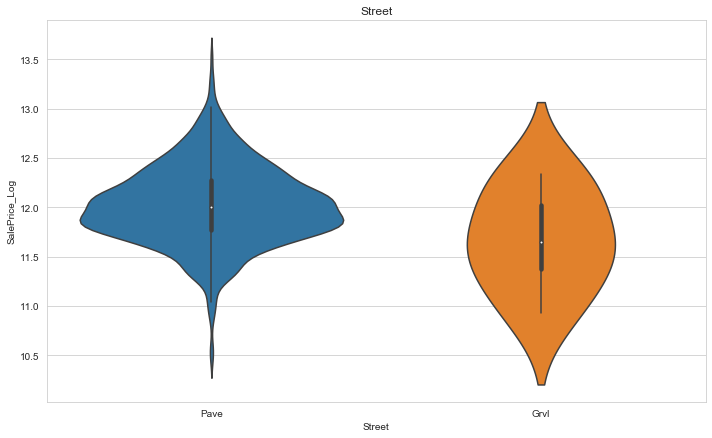

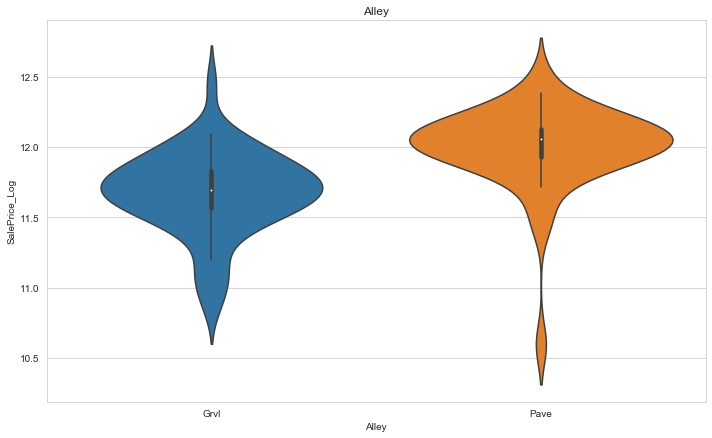

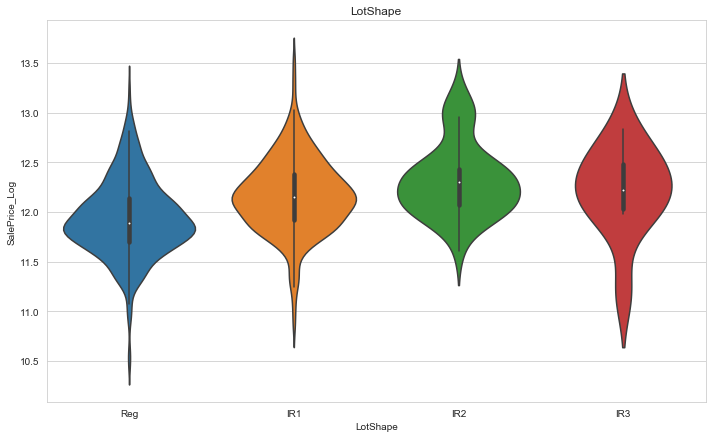

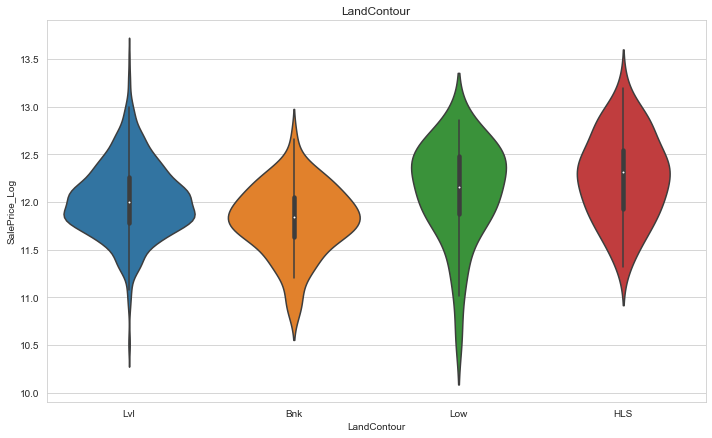

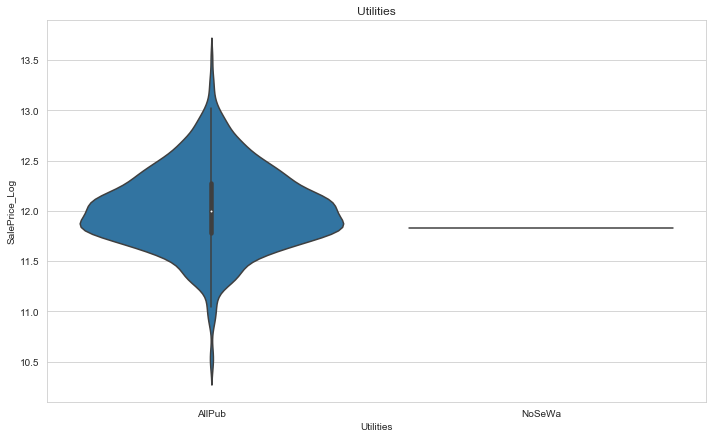

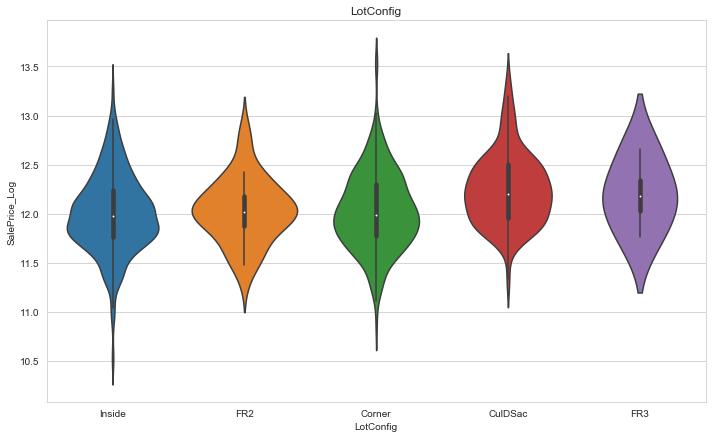

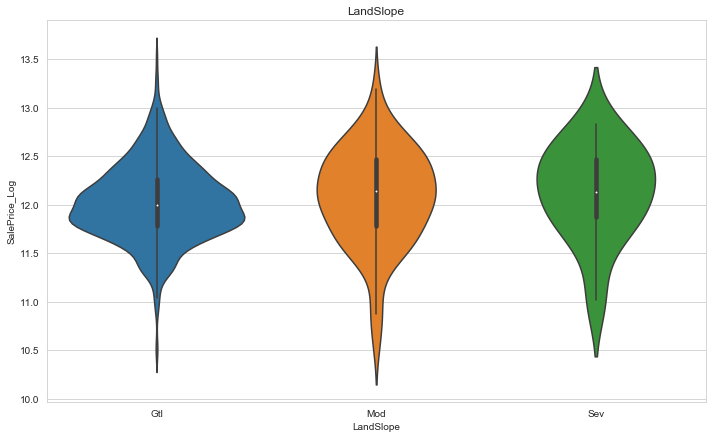

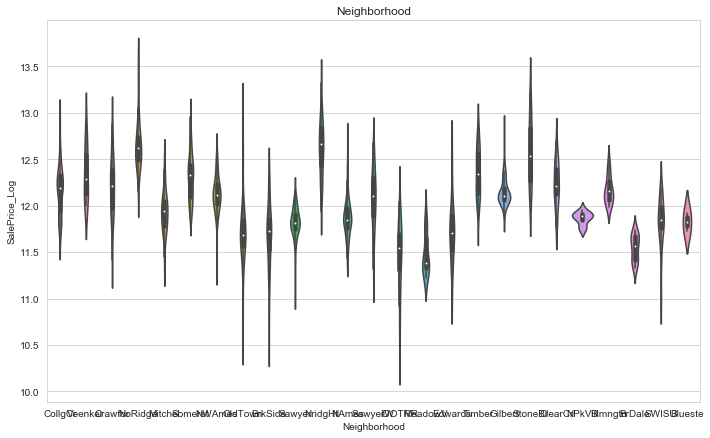

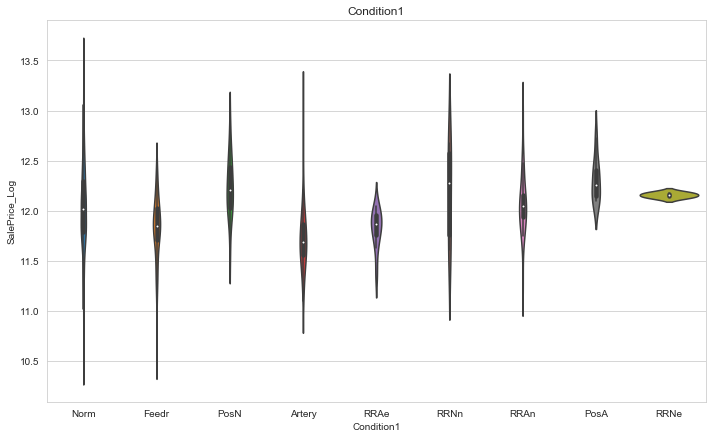

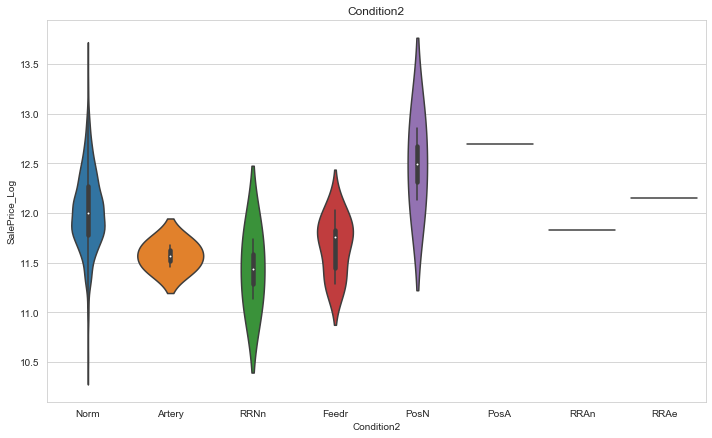

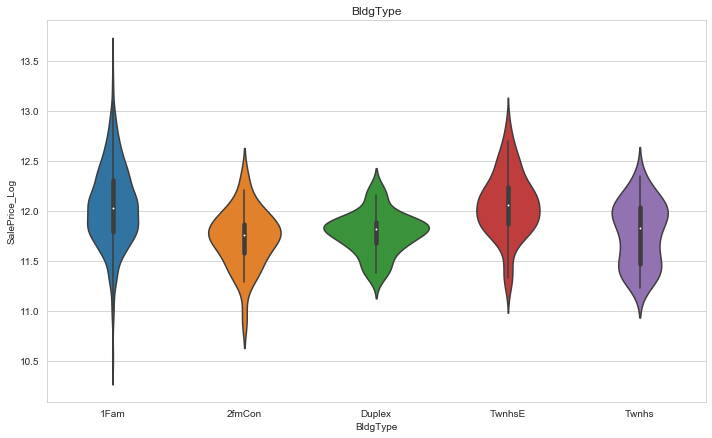

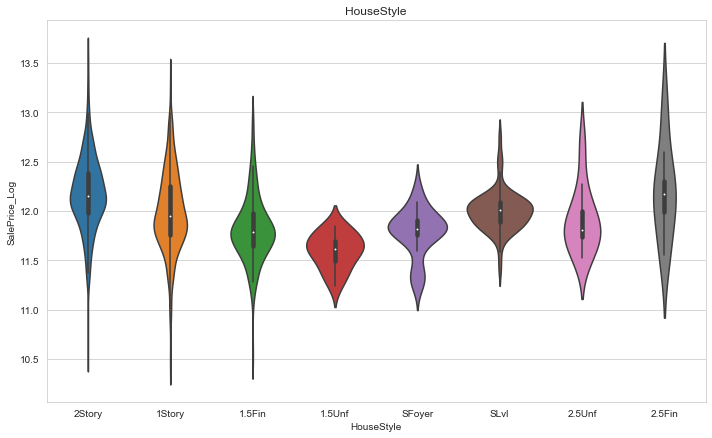

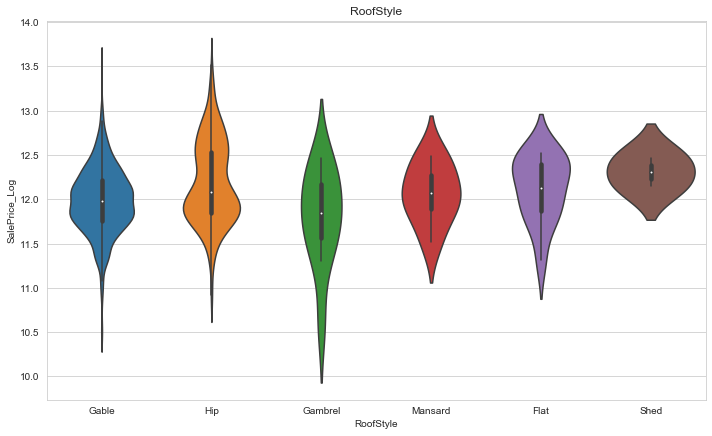

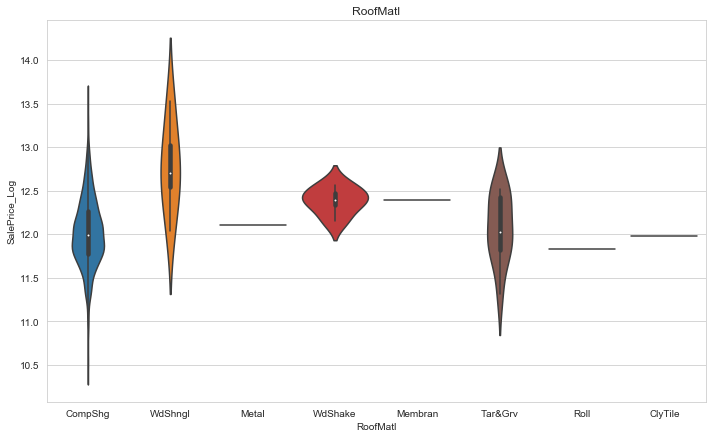

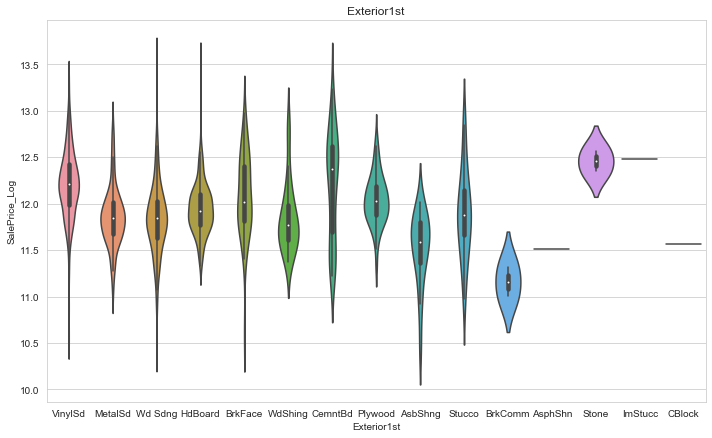

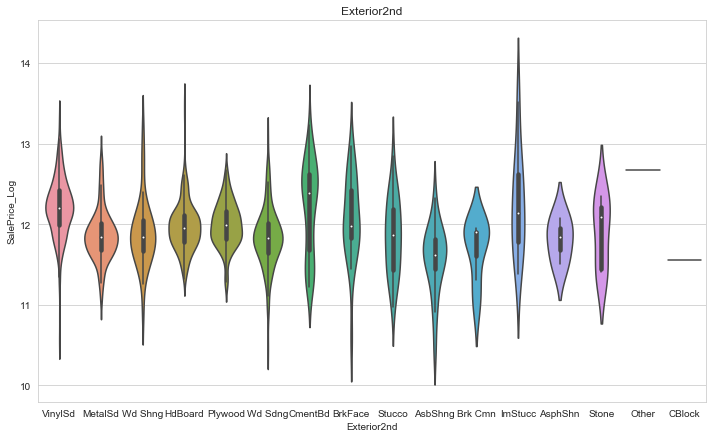

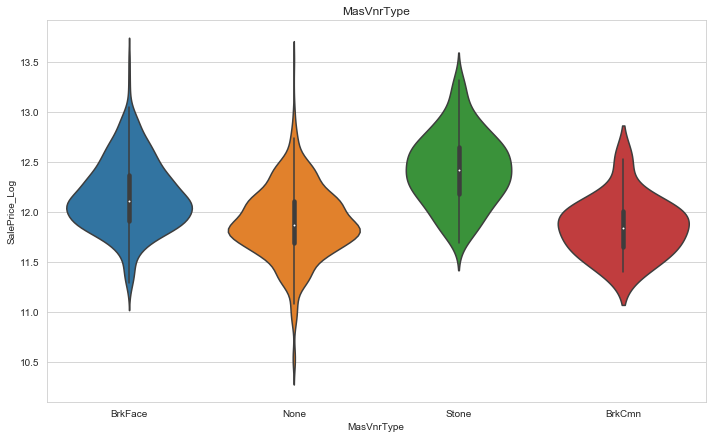

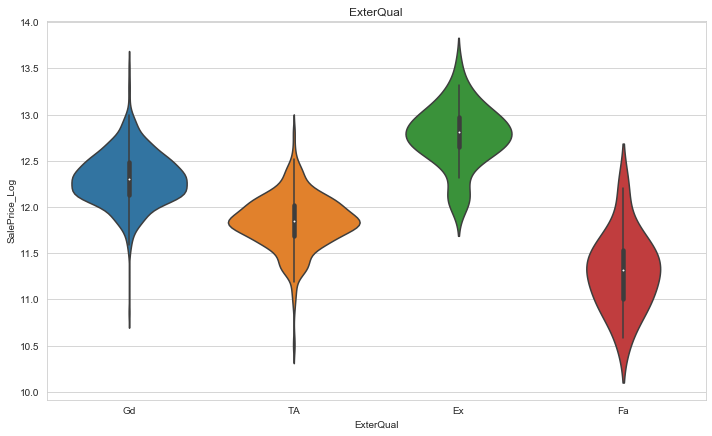

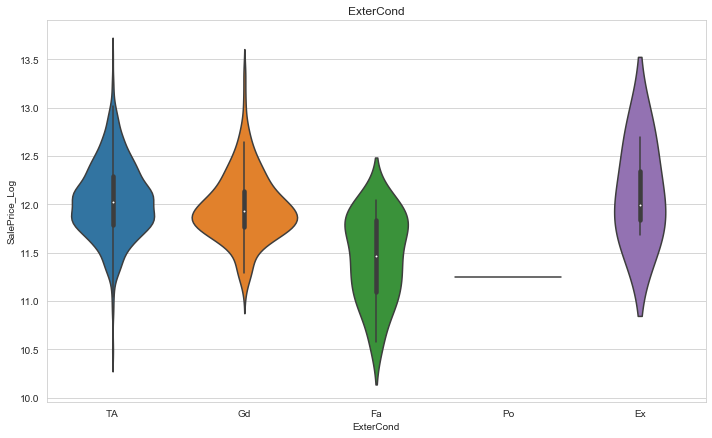

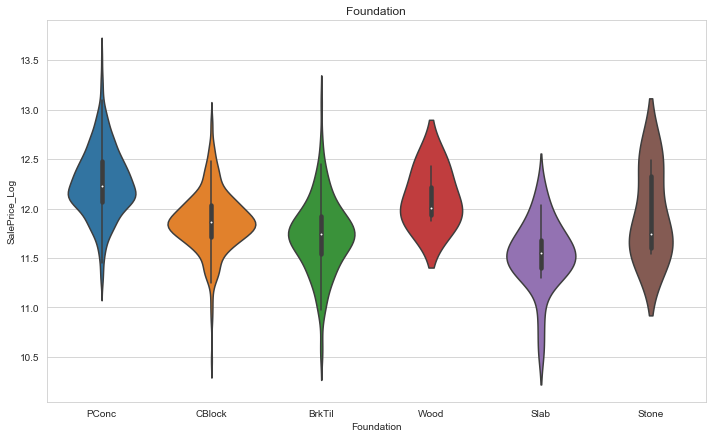

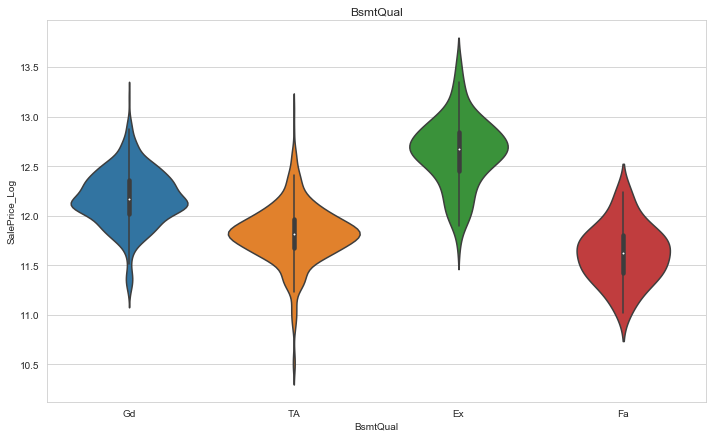

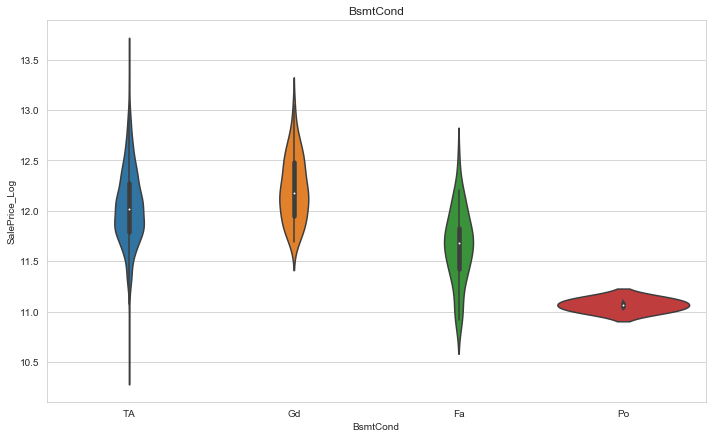

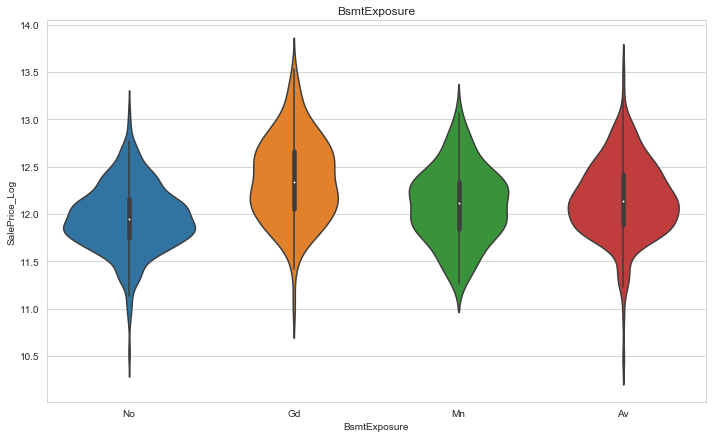

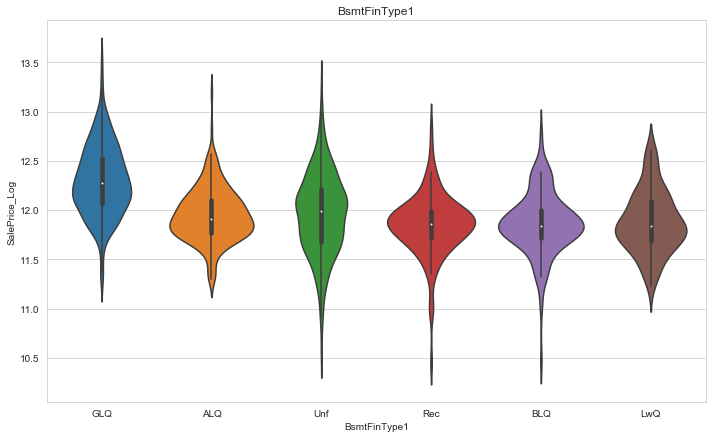

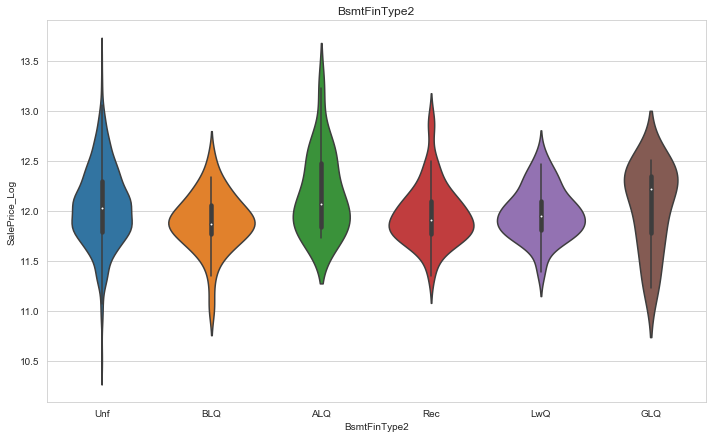

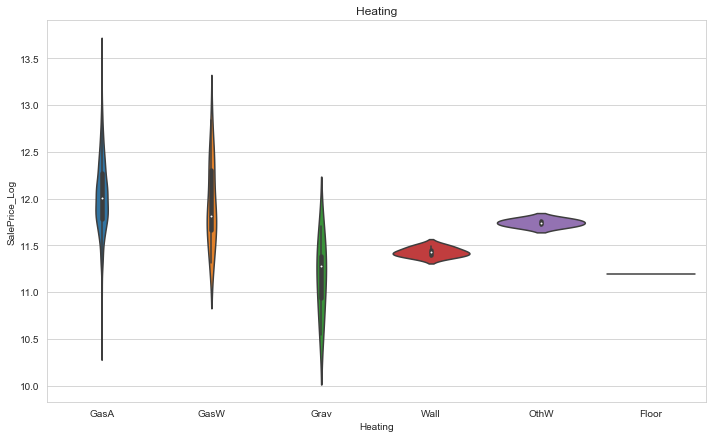

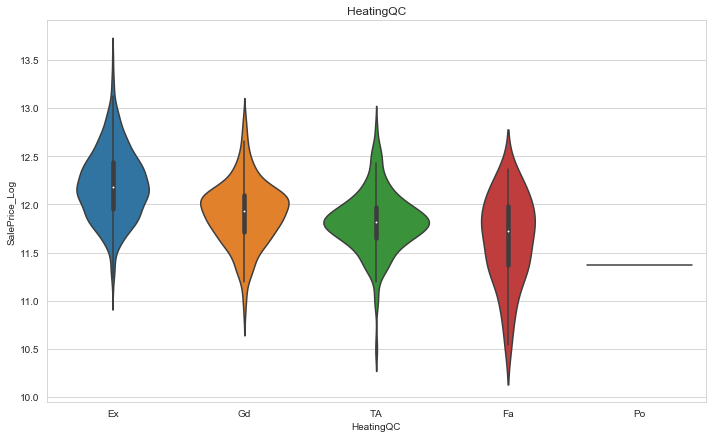

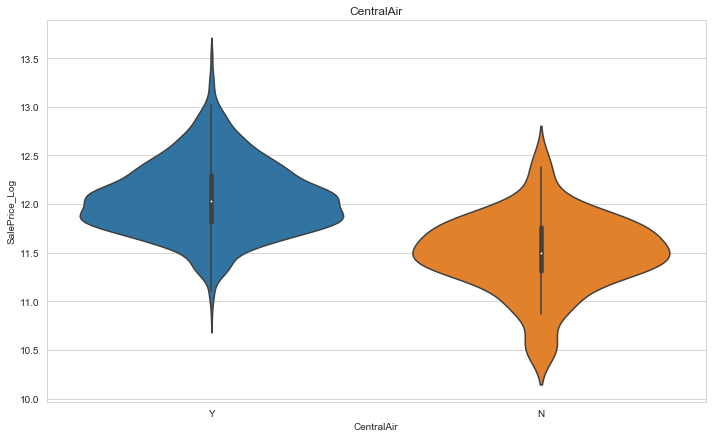

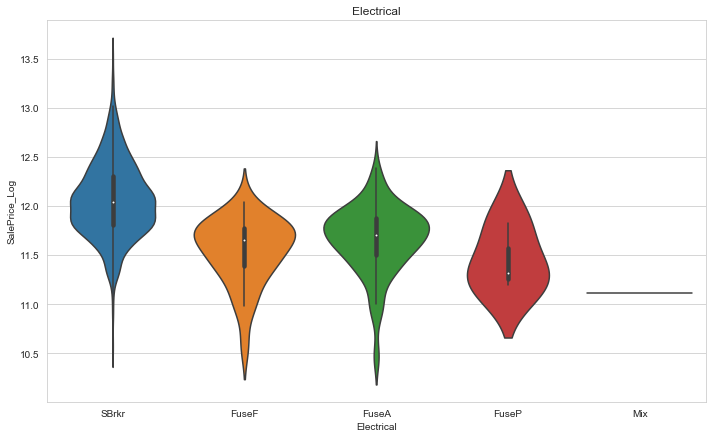

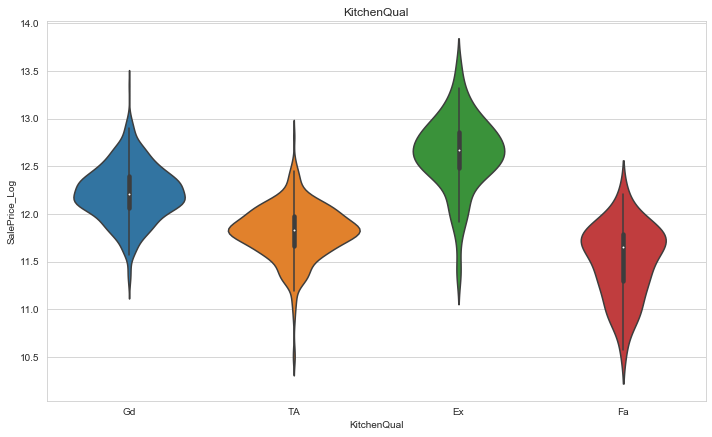

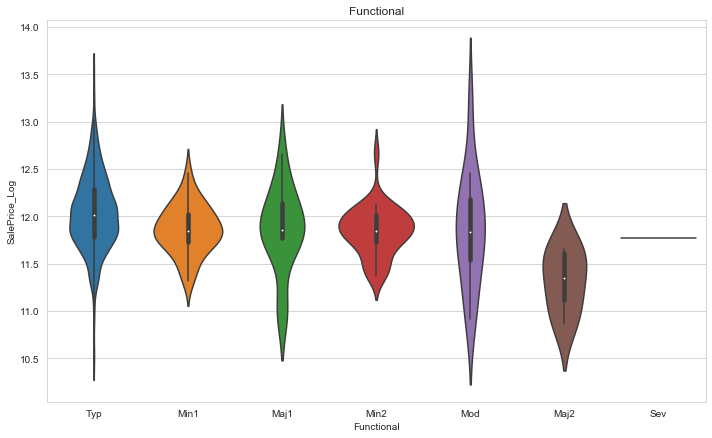

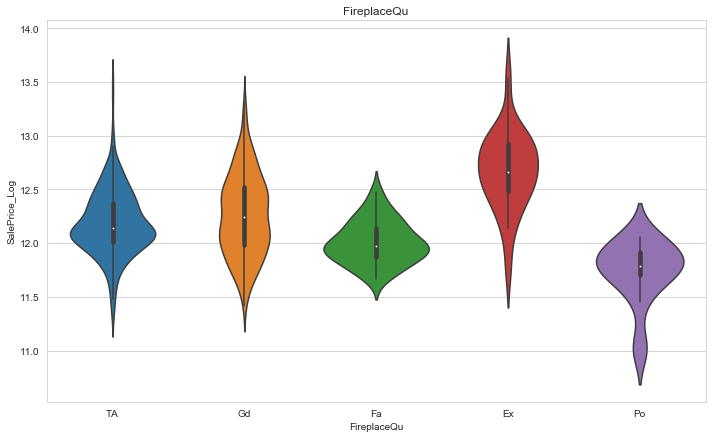

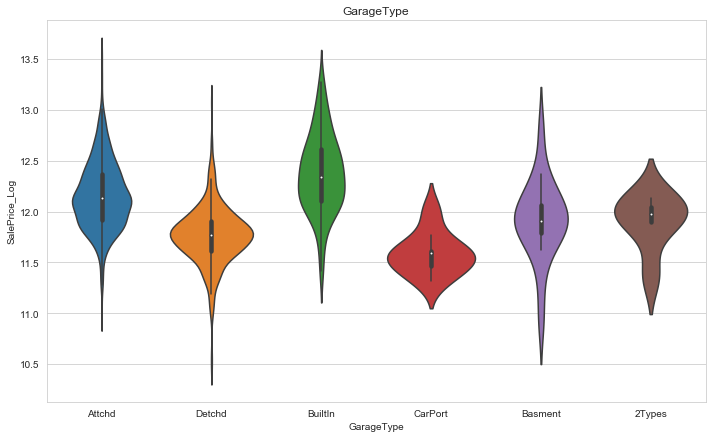

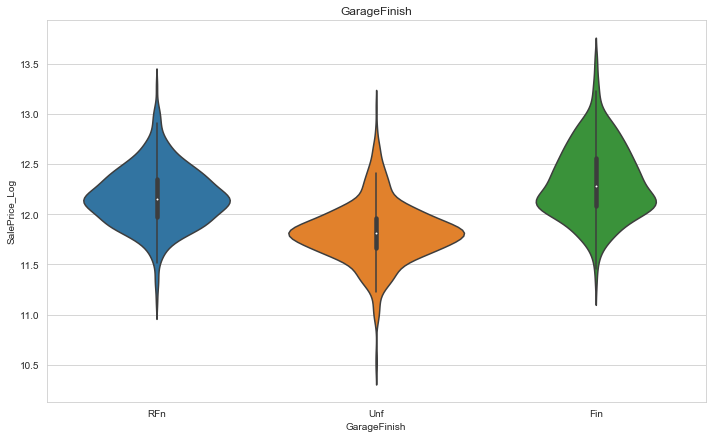

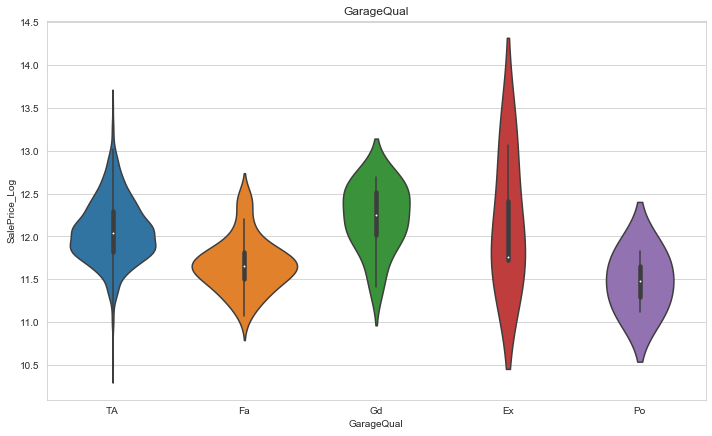

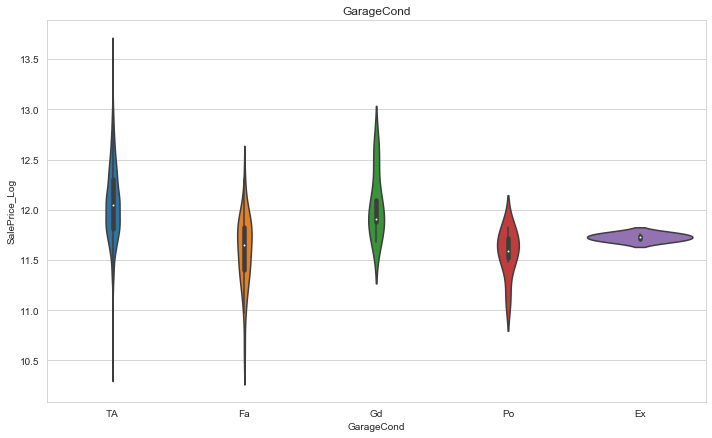

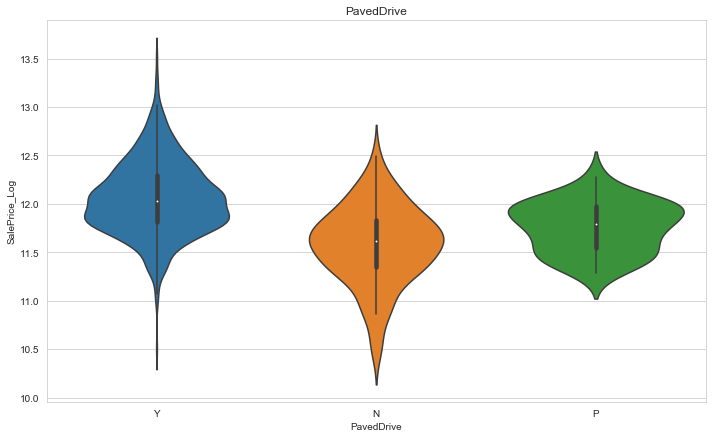

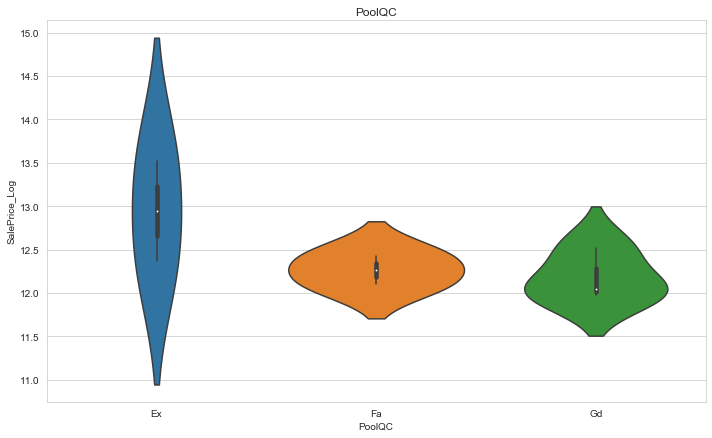

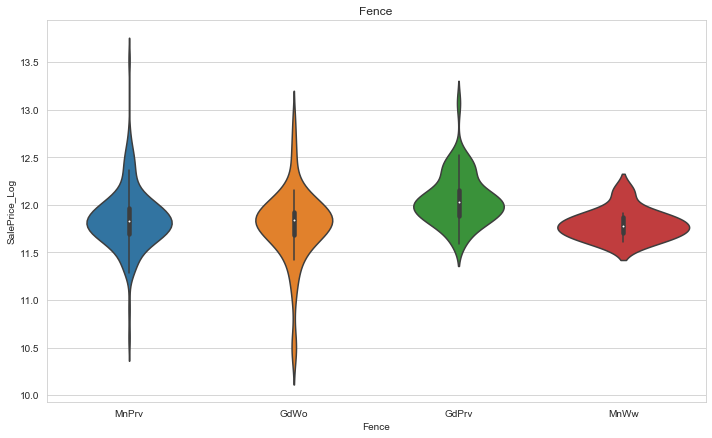

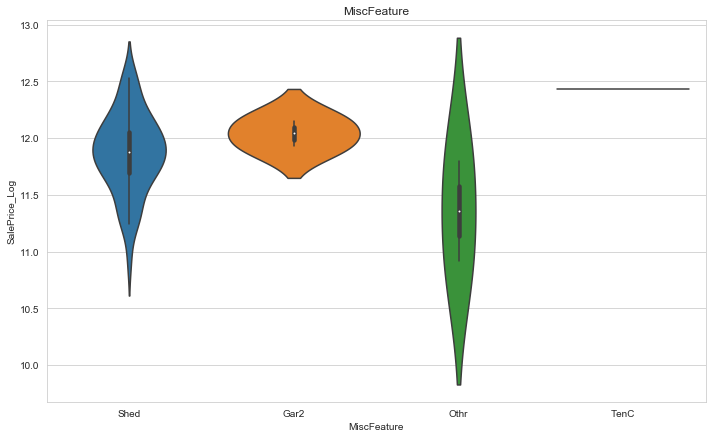

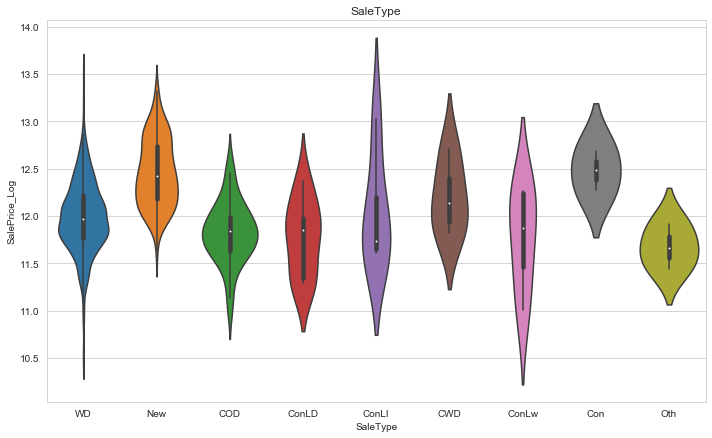

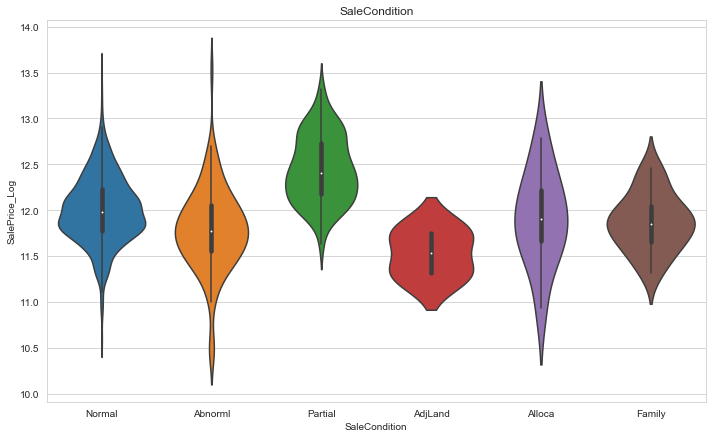

In [65]:
for feature in combined[categorical_columns_list].columns:
    plt.figure(figsize=(10,6))
    sns.violinplot(x=feature,y='SalePrice_Log',data=combined)
    plt.tight_layout()
    plt.title(feature)
    plt.show()

**Null Columns**

In [260]:
null_columns = []
null_values = []
for col in combined.columns:
    if combined[col].isna().sum() == 0:
        pass
    else:
        null_columns.append(col)
        null_values.append(combined[col].isna().sum())
df_null = pd.DataFrame()
df_null['Column'] = null_columns
df_null['Nulls']  = null_values

In [261]:
df_null.sort_values(by='Nulls',ascending=False).style.hide_index()

Column,Nulls
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
SalePrice_Log,1459
SalePrice,1459
FireplaceQu,1420
LotFrontage,486
GarageYrBlt,159
GarageFinish,159


# 2. Replacing Null Values

**Replace the following categorical columns None bc the houses most likely don't have these features**

In [306]:
replace_with_none_list = ['Alley', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
                          'Fence', 'MiscFeature', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                          'BsmtFinType1', 'BsmtFinType2']

for col in replace_with_none_list:
    combined[col] = combined[col].fillna('None')

**Replace these Categorical Variables with the most common instance**

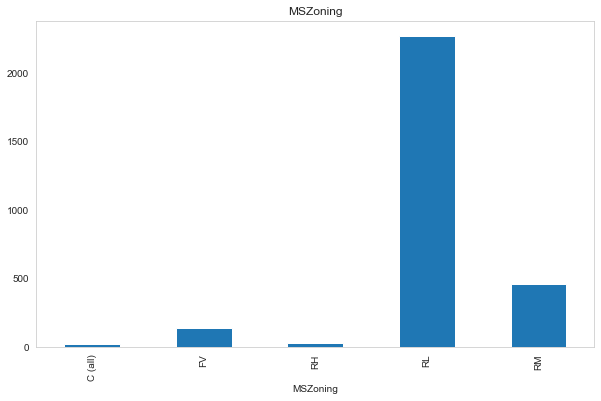

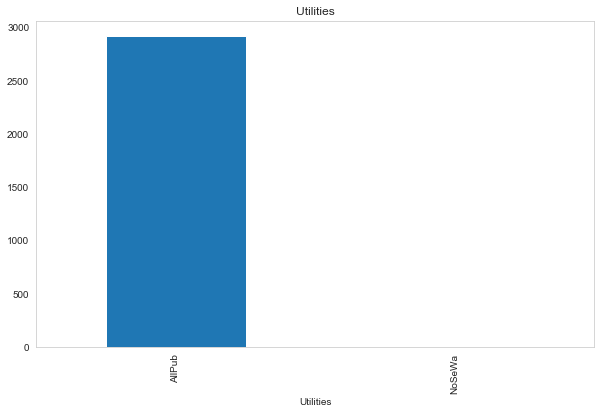

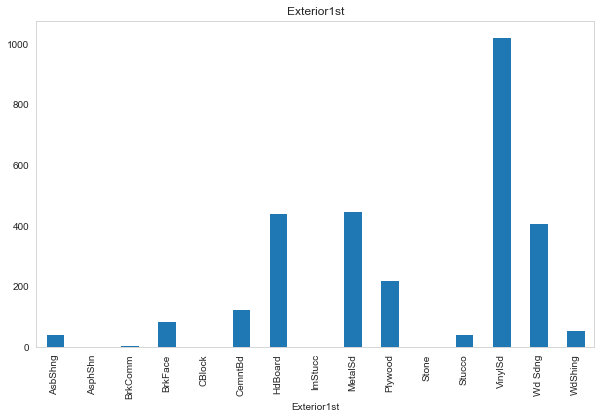

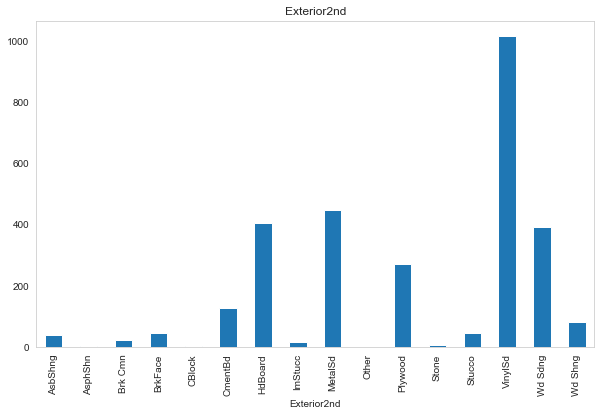

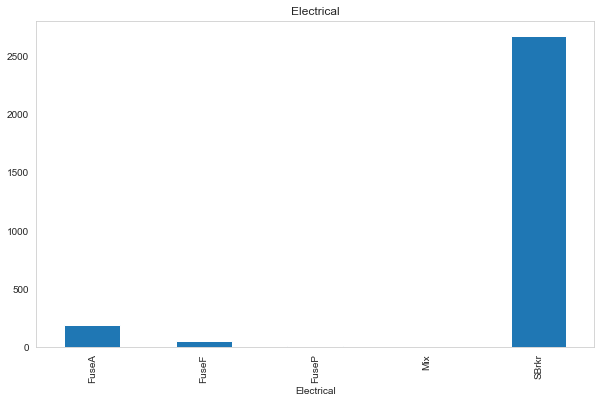

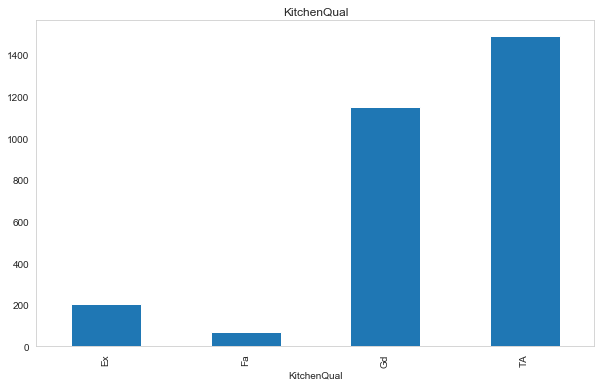

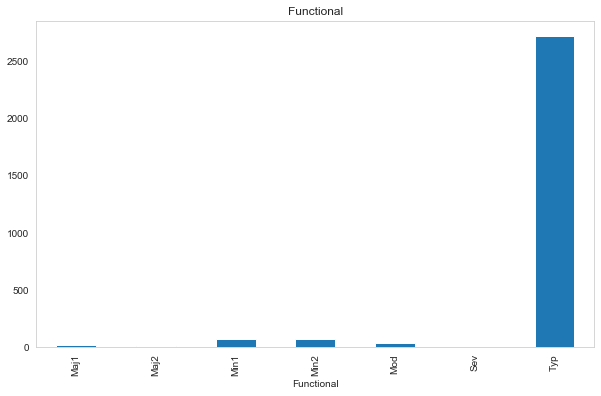

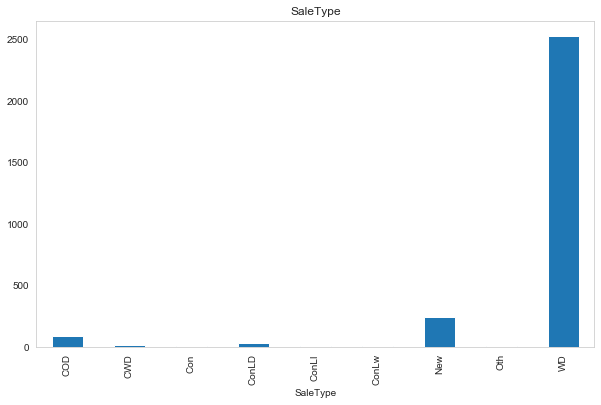

In [234]:
replace_with_common_instance_list = []

for col in combined[categorical_columns_list]:    
    if (col not in replace_with_none_list) & (col in null_columns):
        plt.figure(figsize=(10,6))
        combined.groupby(col)['Id'].count().plot(kind='bar', grid=False)
        plt.title(col)
        plt.show()
        replace_with_common_instance_list.append(col)

In [307]:
for col in replace_with_common_instance_list:
    combined[col] = combined[col].fillna(combined[col].mode()[0])

**The following numerical variables can be filled with 0 bc the house doesn't have them**

In [308]:
replace_with_zero_list = ['MasVnrArea','GarageYrBlt','BsmtFullBath','BsmtUnfSF','BsmtFinSF2','BsmtHalfBath',
                         'BsmtFinSF1','TotalBsmtSF','GarageCars','GarageArea']

for col in replace_with_zero_list:
    combined[col] = combined[col].fillna(0)

**Neighborhood LotFrontage will be replaced by the median LotFrontage that the house resides in neighborhood**

In [309]:
combined.LotFrontage = combined.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

Check if all nulls replaced

In [310]:
for col in combined.columns:
    if combined[col].isna().sum() > 0:
        print(col)

SalePrice
SalePrice_Log


# 3. Establish Baseline RMSLE

**Encode and create dummy variables for categorical columns**

The following variables are really Categorical variables

In [311]:
combined.YrSold = combined.YrSold.astype(str)
combined.MoSold = combined.MoSold.astype(str)
combined.MSSubClass = combined.MSSubClass.astype(str)
combined.OverallCond = combined.OverallCond.astype(str)

Encode Variables

In [312]:
from sklearn.preprocessing import LabelEncoder
label_cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond'] 

encoded_variables = combined[label_cols].copy()

for c in combined[label_cols]:
    lbl = LabelEncoder() 
    lbl.fit(list(encoded_variables[c].values)) 
    encoded_variables[c] = lbl.transform(list(encoded_variables[c].values))

encoded_variables = pd.DataFrame(encoded_variables, columns= (encoded_variables.columns))

Re-Declare Numeric and Categorical Variables

In [313]:
numeric_columns_list = []
categorical_columns_list = []

for col in combined.columns:
    column_var = combined[col].dtype
    column_var = str(column_var)
    if column_var == 'object':
        categorical_columns_list.append(col)
    else:
        numeric_columns_list.append(col)

print('Numeric Columns:', len(numeric_columns_list))
print('Non-Numeric Columns:',len(categorical_columns_list))

numeric_columns_list.remove('Id')
numeric_columns_list.remove('SalePrice')

Numeric Columns: 36
Non-Numeric Columns: 47


In [314]:
dummy_variables = pd.get_dummies(combined[categorical_columns_list].drop(encoded_variables.columns,axis=1))
features = pd.concat([combined[numeric_columns_list], dummy_variables], axis=1)
features = pd.concat([features, encoded_variables], axis=1)

In [315]:
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def RMSLE(predict, actual):
    model_mse = mean_squared_error(predict, actual)
    model_rmse = math.sqrt(model_mse)
    return model_rmse

In [364]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x = features[features.Train == 1].drop(['Train','SalePrice_Log'],axis=1)
y = combined[combined.Train == 1][['SalePrice_Log']]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .20, random_state = 1)
regression_model = LinearRegression()
regression_model.fit(x_train,y_train)

y_predict = regression_model.predict(x_test)

print('RMSE: ',RMSLE(y_test, y_predict))
print('RMSE (Normalized): ', RMSLE(np.floor(np.expm1(y_test)), np.floor(np.expm1(y_predict))))

RMSE:  0.13054643281885922
RMSE (Normalized):  24365.356892100965


**Baseline RMSLE: 0.13838844317414067**

# 4. Feature Engineering

**Data Distributions**

Apply Log Transformations to variables where it reduces skew

In [317]:
for col in features[numeric_columns_list].drop(['Train','SalePrice_Log'],axis=1):
    y = features[col]
    skew = y.skew()
    y_log = np.log1p(features[col])
    log_skew = y_log.skew()
    if 0 in features[col].unique():
        pass
    else:
        if min(skew, log_skew, key=abs) == log_skew:
            print(col)
            features[col] = np.log1p(features[col])

LotFrontage
LotArea
1stFlrSF
GrLivArea
TotRmsAbvGrd


In [318]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x = features[features.Train == 1].drop(['Train','SalePrice_Log'],axis=1)
y = features[features.Train == 1][['SalePrice_Log']]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .20, random_state = 1)
regression_model = LinearRegression()
regression_model.fit(x_train,y_train)

y_predict = regression_model.predict(x_test)

print('RMSE: ',RMSLE(y_test, y_predict))
print('RMSE (Normalized): ', RMSLE(np.floor(np.expm1(y_test)), np.floor(np.expm1(y_predict))))

RMSE:  0.13054643281885922
RMSE (Normalized):  24365.356892100965


# 5. Modeling

In [319]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from sklearn.model_selection import GridSearchCV

def RMSLE(test, predict):
    model_mse = mean_squared_error(test, predict)
    model_rmse = math.sqrt(model_mse)
    return model_rmse

In [320]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

**Random Forest**

In [321]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()#n_estimators = 100
rf.fit(x_train, y_train)
print(rf.score(x_test,y_test))
y_predictedrf = rf.predict(x_test)

RMSLE(y_test, y_predictedrf)

0.8811546339467561


0.1436175920853283

**Lasso**

In [322]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC

lasso = Lasso()
params = {'alpha':[1e-15,1e-10, 1e-8, 1e-4, 1e-3, 1e-2,1, 5, 10, 20, 50,1e1, 1e2, 1e3, 1e5]}
lasso_regressor = GridSearchCV(lasso, params, scoring = 'neg_mean_squared_error',cv=5)
lasso_regressor.fit(x_train,y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

predict_lasso = lasso_regressor.predict(x_test)
RMSLE(y_test,predict_lasso)

{'alpha': 0.001}
-0.01930497756511513


0.12737116407338978

In [323]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold, cross_val_score

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

lasso_regressor = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))

lasso_regressor.fit(x_train,y_train)

predict_lasso = lasso_regressor.predict(x_test)
RMSLE(y_test,predict_lasso)

0.11895957172169246

**Ridge**

In [326]:
from sklearn.linear_model import RidgeCV, Ridge

ridge = Ridge()
params = {'alpha':[1e-15,1e-10, 1e-8, 1e-4, 1e-3, 1e-2,1, 5, 10, 20, 50,1e1, 1e2, 1e3, 1e5]}
ridge_regressor = GridSearchCV(ridge, params, scoring = 'neg_mean_squared_error',cv=5)
ridge_regressor.fit(x_train,y_train)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)
predict_ridge = ridge_regressor.predict(x_test)
RMSLE(y_test,predict_ridge)

/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.72362e-19): result may not be accurate.
  overwrite_a=True).T
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.78297e-19): result may not be accurate.
  overwrite_a=True).T
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.36086e-19): result may not be accurate.
  overwrite_a=True).T
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.45226e-19): result may not be accurate.
  overwrite_a=True).T
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.72573e-17): result may not 

{'alpha': 5}
-0.018923316199769214


0.1291392193727641

In [325]:
from sklearn.linear_model import RidgeCV, Ridge

ridge_regressor = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

ridge_regressor.fit(x_train,y_train)
predict_ridge = ridge_regressor.predict(x_test)
RMSLE(y_test,predict_ridge)

0.13043751359803651

**Elastic**

In [327]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet()
params = {'alpha':[1e-15,1e-10, 1e-8, 1e-4, 1e-3, 1e-2,1, 5, 10, 20, 50,1e1, 1e2, 1e3, 1e5]}
elastic_regressor = GridSearchCV(elastic, params, scoring = 'neg_mean_squared_error',cv=5)
elastic_regressor.fit(x_train, y_train)

print(elastic_regressor.best_params_)
print(elastic_regressor.best_score_)
predict_elastic = elastic_regressor.predict(x_test)
RMSLE(y_test,predict_elastic)

{'alpha': 0.001}
-0.01881031301420636


0.12299312388247577

In [328]:
from sklearn.linear_model import ElasticNetCV

elastic_regressor = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))  
elastic_regressor.fit(x_train, y_train)
predict_elastic = elastic_regressor.predict(x_test)
RMSLE(y_test,predict_elastic)

0.11895957172169246

**Kernal Ridge**

In [329]:
from sklearn.kernel_ridge import KernelRidge

krr = KernelRidge(alpha=1000)
params = {'alpha':[1e-15,1e-8, 1e-2,1,1e1, 1e3, 1e5]}
krr_regressor = GridSearchCV(krr, params, scoring = 'neg_mean_squared_error',cv=5)
krr_regressor.fit(x_train, y_train)

print(krr_regressor.best_params_)
print(krr_regressor.best_score_)

predict_krr = krr_regressor.predict(x_test)
RMSLE(y_test,predict_krr)

{'alpha': 10.0}
-0.0192028348677148


0.131189657156117

**Gboost**

In [330]:
from sklearn.ensemble import GradientBoostingRegressor

gboost = GradientBoostingRegressor()
gboost_regressor = gboost.fit(x_train,y_train)
predict_gboost = gboost_regressor.predict(x_test)

RMSLE(y_test,predict_gboost) #0.12879455202929072 - 3000 0.1287189253192443- 2000

0.12970115669100585

In [342]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators':[2000], 'learning_rate':[.01], 'max_depth':[5], 'min_samples_leaf':[25], 'min_samples_split':[20,25],'random_state':[10,15]}
tuning=GridSearchCV(estimator = GradientBoostingRegressor(), param_grid = params, scoring='r2')
tuning.fit(x_train,y_train)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.01,
  'max_depth': 5,
  'min_samples_leaf': 25,
  'min_samples_split': 20,
  'n_estimators': 2000,
  'random_state': 15},
 0.8940228229967102)

In [343]:
#gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, max_depth=2, max_features='sqrt', min_samples_leaf=10, min_samples_split=25, loss='huber', random_state =10)
gboost = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.01, max_depth=5, max_features='sqrt', min_samples_leaf=25, min_samples_split=20, loss='huber', random_state =15)
gboost = GradientBoostingRegressor()
gboost_regressor = gboost.fit(x_train,y_train)
predict_gboost = gboost_regressor.predict(x_test)

RMSLE(y_test,predict_gboost)

0.12868899023649386

**XGBoost**

In [333]:
from xgboost import XGBRegressor

xgboost = XGBRegressor()

xgboost_regressor = xgboost.fit(x_train,y_train)
predict_xgboost = xgboost_regressor.predict(x_test)

RMSLE(y_test,predict_xgboost) #0.12250854299899443

0.1389378407322833

In [482]:
params = {'learning_rate': [.05], 'n_estimators': [475], 'max_depth':[3],'min_child_weight':[0], 'gamma':[0], 'subsample':[0.5],
          'colsample_bytree':[1],'nthread':[-1],'scale_pos_weight':[1], 'seed':[20], 'reg_alpha':[1e-5]}
tuning=GridSearchCV(estimator = XGBRegressor(), param_grid = params, scoring='r2')
tuning.fit(x_train,y_train)
tuning.best_params_, tuning.best_score_

({'colsample_bytree': 1,
  'gamma': 0,
  'learning_rate': 0.05,
  'max_depth': 3,
  'min_child_weight': 0,
  'n_estimators': 475,
  'nthread': -1,
  'reg_alpha': 1e-05,
  'scale_pos_weight': 1,
  'seed': 20,
  'subsample': 0.5},
 0.8993548450700171)

In [334]:
xgboost = XGBRegressor(learning_rate=0.05,n_estimators=475,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.5,
                                     colsample_bytree=1,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=20,
                                     reg_alpha=1e-5)

xgboost_regressor = xgboost.fit(x_train,y_train)
predict_xgboost = xgboost_regressor.predict(x_test)

RMSLE(y_test,predict_xgboost)

[01:10:22] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[01:10:26] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


0.12834376076989165

**LightGBM**

In [335]:
from lightgbm import LGBMRegressor

#lightgbm = LGBMRegressor(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
lightgbm = LGBMRegressor()
params = {'alpha':[1e-15,1e-10, 1e-8, 1e-4, 1e-3, 1e-2,1, 5, 10, 20, 50,1e1, 1e2, 1e3, 1e5]}
lightgbm_regressor = GridSearchCV(lightgbm, params, scoring = 'neg_mean_squared_error',cv=5)
lightgbm_regressor.fit(x_train, y_train)

print(lightgbm_regressor.best_params_)
print(lightgbm_regressor.best_score_)
predict_lightgbm = lightgbm_regressor.predict(x_test)

RMSLE(y_test,predict_lightgbm)

{'alpha': 1e-15}
-0.017622427384990737


0.1357394507790238

In [336]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
lightgbm_regressor.fit(x_train, y_train)

predict_lightgbm = lightgbm_regressor.predict(x_test)

RMSLE(y_test,predict_lightgbm)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


0.1272576599461278

**StackingCVRegressor**

In [344]:
from mlxtend.regressor import StackingCVRegressor

stack_gen = StackingCVRegressor(regressors=(regression_model, rf, ridge_regressor, lasso_regressor, elastic_regressor, krr_regressor, gboost_regressor, xgboost_regressor, lightgbm_regressor),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)
stack_gen_model = stack_gen.fit(x_train, y_train)
stack_gen_model_predict = stack_gen_model.predict(np.array(x_test))
RMSLE(stack_gen_model_predict, y_test)

/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.69081e-19): result may not be accurate.
  overwrite_a=True).T
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.07307e-19): result may not be accurate.
  overwrite_a=True).T
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.92447e-17): result may not be accurate.
  overwrite_a=True).T
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.9794e-17): result may not be accurate.
  overwrite_a=True).T
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.70456e-18): result may not b

[01:40:40] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:43] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:43] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:46] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:46] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:49] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:49] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is no

/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.72375e-19): result may not be accurate.
  overwrite_a=True).T
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.78759e-19): result may not be accurate.
  overwrite_a=True).T
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.36082e-19): result may not be accurate.
  overwrite_a=True).T
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.72552e-17): result may not be accurate.
  overwrite_a=True).T
/Users/khokibernier/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.79101e-17): result may not 

[01:41:18] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:21] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


0.1329367087458049

In [345]:
models = [regression_model, rf, ridge_regressor, lasso_regressor, elastic_regressor, krr_regressor, gboost_regressor, xgboost_regressor, lightgbm_regressor]
models_str = ['regression_model', 'rf', 'ridge_regressor', 'lasso_regressor', 'elastic_regressor', 'krr_regressor', 'gboost_regressor', 'xgboost_regressor', 'lightgbm_regressor']
ctr=0
for i in models:
    if i == 'stack_gen_model':
        pass
    else:
        print(models_str[ctr], RMSLE(i.predict(x_test),y_test))
    ctr+=1

regression_model 0.13054643281885922
rf 0.1436175920853283
ridge_regressor 0.1291392193727641
lasso_regressor 0.11895957172169246
elastic_regressor 0.11895957172169246
krr_regressor 0.131189657156117
gboost_regressor 0.12868899023649386
xgboost_regressor 0.12834376076989165
lightgbm_regressor 0.1272576599461278


In [357]:
stack_gen_model_list = []
for i in stack_gen_model.predict(np.array(x_test)):
    a = []
    a.append(i)
    stack_gen_model_list.append(a)
stack_gen_model_array = np.asarray(stack_gen_model_list)

**Combining All Models**

In [347]:
n = 10
RMSLE(list(map(sum, zip(regression_model.predict(x_test) * 1/n, 
                  rf.predict(x_test) * 1/n,
                  ridge_regressor.predict(x_test) * 1/n,
                  lasso_regressor.predict(x_test) * 1/n,
                  elastic_regressor.predict(x_test) * 1/n,
                  krr_regressor.predict(x_test) * 1/n,
                  gboost_regressor.predict(x_test) * 1/n,
                  xgboost_regressor.predict(x_test) * 1/n , 
                  lightgbm_regressor.predict(x_test) * 1/n,
                  stack_gen_model_array * 1/n,
                   )))
      , y_test)

0.11979145101341687

# 6. Make and Submit Prediction

In [349]:
stack_gen_model_list2 = []
for i in stack_gen_model.predict(np.asarray(features[features.Train == 0].drop(['Train','SalePrice_Log'],axis=1))):
    a = []
    a.append(i)
    stack_gen_model_list2.append(a)
stack_gen_model_array2 = np.asarray(stack_gen_model_list2)
stack_gen_model_array2

prediction2 = list(map(sum, zip(regression_model.predict(features[features.Train == 0].drop(['Train','SalePrice_Log'],axis=1)) * 1/n, 
                  rf.predict(features[features.Train == 0].drop(['Train','SalePrice_Log'],axis=1)) * 1/n,
                  ridge_regressor.predict(features[features.Train == 0].drop(['Train','SalePrice_Log'],axis=1)) * 1/n,
                  lasso_regressor.predict(features[features.Train == 0].drop(['Train','SalePrice_Log'],axis=1)) * 1/n,
                  elastic_regressor.predict(features[features.Train == 0].drop(['Train','SalePrice_Log'],axis=1)) * 1/n,
                  krr_regressor.predict(features[features.Train == 0].drop(['Train','SalePrice_Log'],axis=1)) * 1/n,
                  gboost_regressor.predict(features[features.Train == 0].drop(['Train','SalePrice_Log'],axis=1)) * 1/n,
                  xgboost_regressor.predict(features[features.Train == 0].drop(['Train','SalePrice_Log'],axis=1)) * 1/n , 
                  lightgbm_regressor.predict(features[features.Train == 0].drop(['Train','SalePrice_Log'],axis=1)) * 1/n,
                  stack_gen_model_array2 * 1/n,
                   )))
prediction2 = np.floor(np.expm1(prediction2))

In [351]:
prediction_values2 = []
for i in prediction2:
    prediction_values2.append(i[0])
test = pd.read_csv('test.csv')
submission_data = {'Id': test.Id, 'SalePrice': prediction_values2}
housing_submission2 = pd.DataFrame(data=submission_data)

In [355]:
housing_submission2.to_csv("submission.csv", index=False)

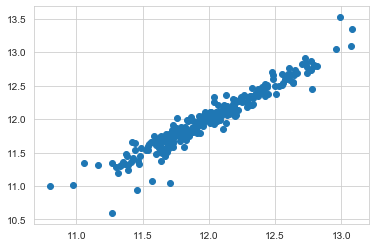

In [353]:
plt.scatter(list(map(sum, zip(regression_model.predict(x_test) * 1/n, 
                  rf.predict(x_test) * 1/n,
                  ridge_regressor.predict(x_test) * 1/n,
                  lasso_regressor.predict(x_test) * 1/n,
                  elastic_regressor.predict(x_test) * 1/n,
                  krr_regressor.predict(x_test) * 1/n,
                  gboost_regressor.predict(x_test) * 1/n,
                  xgboost_regressor.predict(x_test) * 1/n , 
                  lightgbm_regressor.predict(x_test) * 1/n,
                  stack_gen_model_array * 1/n,
                   )))
      , y_test)

p-value = nan
Reject the null, there is heteroscedasticity


-0.00045323389893512153

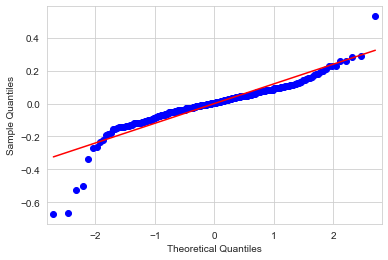

In [365]:
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
X2 = sm.add_constant(predictions)
model2 = sm.OLS(actual,predictions)
est2 = model2.fit()
_, pval, _, f_pval = diag.het_breuschpagan(est2.resid,est2.model.exog)
if pval > 0.05:
    print("p-value = {:.4}".format(pval))
    print('fail to reject the null, so there is no heteroscedasticity')
else:
    print("p-value = {:.4}".format(pval))
    print('Reject the null, there is heteroscedasticity')
sm.qqplot(est2.resid,line='s')
mean_residuals2 = sum(est2.resid) / len(est2.resid)
mean_residuals2

In [366]:
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:          SalePrice_Log   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.918e+06
Date:                Tue, 29 Sep 2020   Prob (F-statistic):                        0.00
Time:                        01:56:01   Log-Likelihood:                          205.36
No. Observations:                 292   AIC:                                     -408.7
Df Residuals:                     291   BIC:                                     -405.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------